In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cnfg
import re
import os
from sqlalchemy import create_engine
from gensim import corpora, models, similarities, matutils
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from gensim.models import word2vec
from gensim import models
from collections import defaultdict
from sklearn.manifold import TSNE

import logging
from sklearn.decomposition import TruncatedSVD, NMF

# logging for gensim (set to INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
                        config['db_user'],
                        config['db_pwd'],
                        config['db_host'],
                        'sephora'))

query_product = """SELECT * FROM sephora_product WHERE category IN ('moisturizers', 'face serums', 'face wash & cleansers',
         'eye creams & treatments', 'face masks', 'moisturizer & treatments',
         'face oils')"""
df_product = pd.read_sql_query(query_product, engine)
# df_product = pd.read_csv('data/sephora_product.csv')
df_product = df_product.set_index('id')
df_product.head(3)

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price
id,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80


In [3]:
query_review = 'SELECT * FROM sephora_product_review'
df = pd.read_sql_query(query_review, engine)
# df = pd.read_csv('data/sephora_review.csv')
df = df[df.rating <= 3]
df.head()

,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_id
3,P38217,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]",248c904c-6e30-4929-8228-87b03ad7a921
9,P38217,,"i like it, but not so crazy about the smell.",3,None,combination,medium,None,tweezerama,[foamy],72c2a20a-be1c-46dc-a2cd-142f2110a05d
18,P38217,Stings my eyes,Returned this product as it was to foamy to us...,1,None,normal,light,None,nancihi,[foamy],ebf96058-5203-4494-9a6c-2bb74099ad23
35,P38217,Wanted to like this but . . .,I received a sample of this cleanser and reall...,2,None,combination,olive,None,rsav,None,639284c9-016e-4bfa-a136-e08e131beefb
43,P38217,Murad cleaners,Good cleanser but I do not care for the scent....,2,None,combination,medium,None,Debedot,None,477b3329-f764-4935-8980-1e24a223f2b6


In [4]:
# df = df.set_index('review_id')

# Split review_text into sentences
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs'])
tokenizer = PunktSentenceTokenizer(punkt_param)
tokenizer.tokenize('Dr. Smith is a doctor. He is the best ... not')

['Dr. Smith is a doctor.', 'He is the best ... not']

In [5]:
df['review_sentences'] = df['review_text'].map(lambda text: tokenizer.tokenize(text))

In [6]:
sample_review_index = 1
print(df.iloc[sample_review_index]['review_text'])
df.iloc[sample_review_index]['review_sentences']

i like it, but not so crazy about the smell.


['i like it, but not so crazy about the smell.']

In [7]:
# Build a new dataframe with each sentence as a document
review_ids = []
review_sentences = []
for review in df.as_matrix():
    curr_review_id = review[-2]
    curr_review_sentences = review[-1]
    review_ids += [curr_review_id] * len(curr_review_sentences)
    review_sentences += curr_review_sentences
    
df_review_sentences = pd.DataFrame({'review_id': review_ids, 'sentence': review_sentences})
df_review_sentences.head()

,review_id,sentence
0,248c904c-6e30-4929-8228-87b03ad7a921,"I tried this cleanser at a friends house, and ..."
1,248c904c-6e30-4929-8228-87b03ad7a921,"I have combination skin, oily t-zone with flak..."
2,248c904c-6e30-4929-8228-87b03ad7a921,"After washing my face with this cleanser, my s..."
3,248c904c-6e30-4929-8228-87b03ad7a921,"However, it has been a week and my pores very ..."
4,72c2a20a-be1c-46dc-a2cd-142f2110a05d,"i like it, but not so crazy about the smell."


In [8]:
df_review_sentences.shape

(100051, 2)

In [9]:
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    return [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]

## TF-IDF

In [10]:
def get_word_weights(docs):
    tfidf = TfidfVectorizer(stop_words=frozenset(), 
                            tokenizer=tokenize,
                            ngram_range=(1,1))
    tfidf.fit(docs)
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(lambda: max_idf,
                                    [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    return word2weight
    
test_docs2 = ["dog cat fish","dog cat cat","fish bird", 'bird fish. bird', 'blah cat', 'tata harper']
get_word_weights(test_docs2)

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'bird': 1.8472978603872037,
             'blah': 2.2527629684953681,
             'cat': 1.5596157879354227,
             'dog': 1.8472978603872037,
             'fish': 1.5596157879354227,
             'harper': 2.2527629684953681,
             'tata': 2.2527629684953681})

## Word2Vec

In [11]:
w2v = models.KeyedVectors.load_word2vec_format("../GoogleNews-vectors-negative300.bin",binary=True)

2017-08-23 10:52:18,444 : INFO : loading projection weights from ../GoogleNews-vectors-negative300.bin
2017-08-23 10:53:25,614 : INFO : loaded (3000000, 300) matrix from ../GoogleNews-vectors-negative300.bin


In [12]:
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
# w2v['moisturizer']

In [13]:
w2v.most_similar(positive=['breakouts'], topn=25)

2017-08-23 10:53:25,628 : INFO : precomputing L2-norms of word weight vectors


[('Breakouts', 0.4931666851043701),
 ('Pullbacks', 0.44811978936195374),
 ('retracements', 0.44314947724342346),
 ('negative_divergences', 0.4385339021682739),
 ('ascending_triangle_formation', 0.4347585439682007),
 ('downtrending', 0.4336913228034973),
 ('optionable', 0.4287429451942444),
 ('QCOR', 0.42023026943206787),
 ('breakout', 0.4135875701904297),
 ('ALLT', 0.4107140898704529),
 ('Aud_Usd', 0.405377060174942),
 ('overbought_oversold', 0.4032655358314514),
 ('TZOO', 0.40304189920425415),
 ('upmoves', 0.4025312662124634),
 ('dojis', 0.39710044860839844),
 ('CSIQ', 0.396085262298584),
 ('CROX', 0.39557570219039917),
 ('AKRX', 0.3948154151439667),
 ('DSTI', 0.3942748010158539),
 ('CYCC', 0.39323264360427856),
 ('largecap_stocks', 0.3913867473602295),
 ('stochastics', 0.39073675870895386),
 ('microcap_stocks', 0.3889700770378113),
 ('MACD_divergence', 0.3887573480606079),
 ('bearish_engulfing', 0.3871125280857086)]

In [14]:
'review' in w2v.vocab

True

In [15]:
df_review_sentences['tokenized_words'] = df_review_sentences['sentence'].map(lambda sentence: tokenize(sentence))
df_review_sentences['tokenized_filtered_words'] = df_review_sentences['tokenized_words'].map(
    lambda tokenized_words: [word for word in tokenized_words if word in w2v.vocab])
df_review_sentences['tokenized_filtered_words_length'] = df_review_sentences['tokenized_filtered_words'].map(
    lambda tokenized_filtered_words: len(tokenized_filtered_words))

In [16]:
# Remove sentences that have no words
df_review_sentences = df_review_sentences[df_review_sentences.tokenized_filtered_words_length > 0]
df_review_sentences = df_review_sentences.reset_index()
word2weight = get_word_weights(df_review_sentences['sentence'])
word2weight

defaultdict(<function __main__.get_word_weights.<locals>.<lambda>>,
            {'holidays': 10.428169828466624,
             'dreams': 11.408999081478349,
             'destabilizes': 11.814464189586515,
             'tooth': 11.408999081478349,
             'dissapointing': 10.428169828466624,
             'shirt': 10.715851900918404,
             'umph': 11.814464189586515,
             'zippy': 11.814464189586515,
             'slapped': 11.408999081478349,
             'erode': 11.814464189586515,
             'faith': 10.31038679281024,
             'flawless': 9.1064139884843041,
             'replied': 11.814464189586515,
             'praise': 10.561701221091147,
             'unscrew': 9.6172396122502946,
             'ingredients:ascorbyl': 11.814464189586515,
             'substitute': 10.109716097348089,
             'hydration': 6.4817453963211449,
             'whipped': 9.0736241656613128,
             'concealor': 11.408999081478349,
             'skittles': 11.4089990

In [17]:
# For each sentence, find word2vec vector
# np.mean(w2v[['it\'s', 'is', 'moisturizer', 'reviews']], axis=0)
def word2vec_tfidf(tokenized_filtered_words):
    return np.mean([w2v[w] * word2weight[w]
             for w in tokenized_filtered_words], axis=0)

word2vec_tfidf(['apple', 'banana']).shape

(300,)

In [18]:
df_review_sentences['word2vec'] = df_review_sentences['tokenized_filtered_words'].map(
    # lambda tokenized_filtered_words: np.mean(w2v[tokenized_filtered_words], axis=0)
    lambda tokenized_filtered_words: word2vec_tfidf(tokenized_filtered_words)
)
df_review_sentences.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec
0,0,248c904c-6e30-4929-8228-87b03ad7a921,"I tried this cleanser at a friends house, and ...","[i, tried, this, cleanser, at, a, friends, hou...","[i, tried, this, cleanser, at, friends, house,...",12,"[0.520117, -0.108023, 0.450239, 0.52766, -0.32..."
1,1,248c904c-6e30-4929-8228-87b03ad7a921,"I have combination skin, oily t-zone with flak...","[i, have, combination, skin, oily, t, zone, wi...","[i, have, combination, skin, oily, t, zone, wi...",16,"[-0.145785, 0.131083, 0.00567749, 0.335053, -1..."
2,2,248c904c-6e30-4929-8228-87b03ad7a921,"After washing my face with this cleanser, my s...","[after, washing, my, face, with, this, cleanse...","[after, washing, my, face, with, this, cleanse...",22,"[-0.0107178, 0.344289, 0.0608665, 0.136298, -0..."
3,3,248c904c-6e30-4929-8228-87b03ad7a921,"However, it has been a week and my pores very ...","[however, it, has, been, a, week, and, my, por...","[however, it, has, been, week, my, pores, very...",22,"[0.140816, 0.620424, -0.23117, 0.109888, -0.60..."
4,4,72c2a20a-be1c-46dc-a2cd-142f2110a05d,"i like it, but not so crazy about the smell.","[i, like, it, but, not, so, crazy, about, the,...","[i, like, it, but, not, so, crazy, about, the,...",10,"[0.214878, -0.0328662, 0.166154, 0.303838, -0...."


In [19]:
# pd.DataFrame(df_review_sentences['word2vec'].values.tolist())

In [20]:
sentence_word_vectors = np.array(df_review_sentences['word2vec'].values.tolist())

## Clustering Functions

In [21]:
def plot_kmeans_inertia(data):
    """Figure out optimized number of clusters for KMeans"""
    max_number_clusters = 20
    inertia_values = []
    for cluster_count in range(1, max_number_clusters+1):
        print('fitting cluster ', cluster_count)
        km = KMeans(n_clusters=cluster_count)
        km.fit(data)
        inertia_values.append(km.inertia_)

    plt.plot(range(1, max_number_clusters+1), inertia_values)

## K-Means

In [63]:
sentence_word_vectors.shape

(99469, 300)

In [64]:
cluster_count = 50
number_sentences = sentence_word_vectors.shape[0]
df_review_sentences_truncated = df_review_sentences.iloc[0:number_sentences, :]
sentence_word_vectors_truncated = sentence_word_vectors[0:number_sentences, :]
sentence_word_vectors_truncated = normalize(sentence_word_vectors_truncated)
sentence_word_vectors_truncated.shape

(99469, 300)

In [65]:
# plot_kmeans_inertia(sentence_word_vectors_truncated)

In [66]:
km = MiniBatchKMeans(n_clusters=cluster_count)
review_word2vec_clusters = km.fit_predict(sentence_word_vectors_truncated)
dists = km.transform(sentence_word_vectors_truncated)
disd_df = pd.DataFrame(dists)
nearest_to_centers = list(disd_df.idxmin(axis=0))
cluster_sentence_counts = []

for i in range(cluster_count):
    word2vec_review_cluster = df_review_sentences_truncated.loc[review_word2vec_clusters == i]['sentence']
    nearest_to_center_sentence_index = nearest_to_centers[i] 
    cluster_sentence_count = word2vec_review_cluster.shape[0]
    cluster_sentence_counts.append(cluster_sentence_count)
    print('Cluster {} has {} sentences'.format(i, cluster_sentence_count))
    print(df_review_sentences.iloc[nearest_to_center_sentence_index]['sentence'])
    
    data_cluster_file = 'data/cluster_reviews/cluster_' + str(i) + '.txt'
    cluster_file = open(data_cluster_file, 'w') 
    for review_text in word2vec_review_cluster.as_matrix():
        cluster_file.write(review_text + '\n')
    cluster_file.close()

Cluster 0 has 1490 sentences
But really, I was disappointed.
Cluster 1 has 2627 sentences
I feel a nasty residue after rinsing and I always feel the need to go in with a harsh scrub after just because I still feel it on top of my skin.I see no difference in fine lines, and I've used this product so many times (it was the deluxe size - I still have almost half the jar left) and I've tried to like it but I just can't.Big miss on this one.
Cluster 2 has 602 sentences
I will probably not repurchase.
Cluster 3 has 2048 sentences
I mean I have mega oily skin and heard people saying it's great for oily skin types so I got the travel size to try and I mean it's moisturizers like it's supposed to but doesn't help at all with keeping my oil under control and idk why But the smell nope not for me at first I was like ok it's not a bad scent but now that I'm using it it smells like rotten eggs (aka sulphur ) which is weird cuz every one is saying that they love the smell but I do not which is anoth

Cluster 47 has 4 sentences
I liked the texture on my hand when I was trying it out, but it was too greasy around the eyes.
Cluster 48 has 6033 sentences
So I was so excited to try this product for over months when finally get to my local Sephora I run away and get it .. The first two times work on my foundation amazingggg so I decide to use at night and then my skin don't have any difference then I start think well maybe it's just an oil for use with foundations then at my 3 day I use it again expecting that glow and nothing for some reason on my skin only work two times after that leave my skin so creasy and oily and I really want to love this product but unfortunately the hype it's bigger that the expectations maybe you should try it before buy it
Cluster 49 has 5963 sentences
I have gotten the Glam Glow power mud before- which I loved- you can see it literally pulling the blackheads and dirt out as it dries on your skin...this mask is a little milkier (less thick) however it needs a

<Container object of 50 artists>

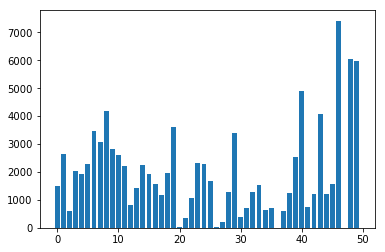

In [67]:
plt.bar(range(0, cluster_count), cluster_sentence_counts)

In [68]:
disd_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.914052,0.772722,1.052575,0.808629,0.858118,0.851728,0.787585,0.766014,0.786108,0.808109,...,0.780789,0.929407,0.681202,0.801541,0.723696,0.840511,0.811627,0.825982,0.776386,0.752457
1,0.968130,0.738500,1.116997,0.823556,0.782336,0.930833,0.805730,0.848927,0.804933,0.754715,...,0.869801,1.053941,0.858772,0.771616,0.947758,0.918491,0.823048,0.853626,0.865646,0.740201
2,0.932747,0.701146,1.006549,0.817985,0.510548,0.821256,0.594703,0.779004,0.528351,0.643323,...,0.792674,0.937456,0.734236,0.638985,0.868710,0.790836,0.702267,0.818721,0.763408,0.628213
3,0.818678,0.666176,1.006247,0.795250,0.606432,0.732799,0.645449,0.712618,0.669536,0.656669,...,0.716677,0.936004,0.706356,0.585948,0.828107,0.704621,0.624028,0.743694,0.670583,0.563096
4,0.777745,0.693503,0.982260,0.659578,0.771535,0.785278,0.668326,0.706778,0.755008,0.741744,...,0.518256,0.808920,0.708720,0.607306,0.611565,0.669778,0.590264,0.707201,0.625004,0.632807


In [69]:
len(review_word2vec_clusters)

99469

In [70]:
# Create vector of sentence to cluster number
df_sentence_cluster = pd.DataFrame({})
cluster_columns = ['cluster_' + str(i) for i in range(0, cluster_count)]
for i in range(0, cluster_count):
    cluster_column = cluster_columns[i]
    df_sentence_cluster[cluster_column] = (review_word2vec_clusters == i).astype(int)
    
df_sentence = pd.concat([df_review_sentences, df_sentence_cluster], axis=1)
df_sentence[df_sentence['cluster_0'] == 1].head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,cluster_0,cluster_1,cluster_2,...,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49
13,15,477b3329-f764-4935-8980-1e24a223f2b6,I'm not overly excited about this product.,"[i'm, not, overly, excited, about, this, product]","[not, overly, excited, about, this, product]",6,"[0.361667, 0.0746536, 0.0452938, -0.13013, -0....",1,0,0,...,0,0,0,0,0,0,0,0,0,0
184,187,10d773be-9278-4215-b89b-7c5d47acfdea,"Not wowed by this after a few uses, but not di...","[not, wowed, by, this, after, a, few, uses, bu...","[not, wowed, by, this, after, few, uses, but, ...",11,"[0.441721, 0.0681533, 0.67258, 0.110842, -0.13...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
192,195,796072ee-4a0b-4c0e-b48d-d3f492ba33db,"Wasn't wowed after first use, so I'm not inter...","[wasn't, wowed, after, first, use, so, i'm, no...","[wasn't, wowed, after, first, use, so, not, in...",8,"[0.468928, 0.013809, 0.444061, 0.0184166, -0.6...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
215,218,83ba8486-1829-4a23-b272-e6af6967b8ca,Disappointed!,[disappointed],[disappointed],1,"[0.144416, 1.0044, 1.33227, -0.718175, 0.32916...",1,0,0,...,0,0,0,0,0,0,0,0,0,0
370,374,9f5bec11-3227-4816-9dcd-81dabc6f9115,"I'm disheartened, because I love the product s...","[i'm, disheartened, because, i, love, the, pro...","[disheartened, because, i, love, the, product,...",19,"[0.254863, 0.317779, 0.0582936, 0.105271, -0.5...",1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merging Review Sentences with Products

In [71]:
df_sentence_product = pd.merge(df_sentence, df, on='review_id', how='left')
df_sentence_product.head()

,index,review_id,sentence,tokenized_words,tokenized_filtered_words,tokenized_filtered_words_length,word2vec,cluster_0,cluster_1,cluster_2,...,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags,review_sentences
0,0,248c904c-6e30-4929-8228-87b03ad7a921,"I tried this cleanser at a friends house, and ...","[i, tried, this, cleanser, at, a, friends, hou...","[i, tried, this, cleanser, at, friends, house,...",12,"[0.520117, -0.108023, 0.450239, 0.52766, -0.32...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
1,1,248c904c-6e30-4929-8228-87b03ad7a921,"I have combination skin, oily t-zone with flak...","[i, have, combination, skin, oily, t, zone, wi...","[i, have, combination, skin, oily, t, zone, wi...",16,"[-0.145785, 0.131083, 0.00567749, 0.335053, -1...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
2,2,248c904c-6e30-4929-8228-87b03ad7a921,"After washing my face with this cleanser, my s...","[after, washing, my, face, with, this, cleanse...","[after, washing, my, face, with, this, cleanse...",22,"[-0.0107178, 0.344289, 0.0608665, 0.136298, -0...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
3,3,248c904c-6e30-4929-8228-87b03ad7a921,"However, it has been a week and my pores very ...","[however, it, has, been, a, week, and, my, por...","[however, it, has, been, week, my, pores, very...",22,"[0.140816, 0.620424, -0.23117, 0.109888, -0.60...",0,0,0,...,"Nice, but not great for combination skin","I tried this cleanser at a friends house, and ...",3,None,combination,fair,None,jenlines22,"[hydrating, creamy]","[I tried this cleanser at a friends house, and..."
4,4,72c2a20a-be1c-46dc-a2cd-142f2110a05d,"i like it, but not so crazy about the smell.","[i, like, it, but, not, so, crazy, about, the,...","[i, like, it, but, not, so, crazy, about, the,...",10,"[0.214878, -0.0328662, 0.166154, 0.303838, -0....",0,0,0,...,,"i like it, but not so crazy about the smell.",3,None,combination,medium,None,tweezerama,[foamy],"[i like it, but not so crazy about the smell.]"


In [72]:
df_sentence_products_clusters = df_sentence_product[cluster_columns + ['product_id']].groupby(['product_id']).sum()
df_sentence_products_clusters.head() # Unnormalized, Uncentered

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47,cluster_48,cluster_49
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,0,0,0,1,2,3,3,2,1,3,...,1,2,4,1,1,3,3,0,6,3
P102504,2,6,0,3,4,11,3,5,5,2,...,8,2,10,4,0,6,14,0,17,3
P107306,8,5,0,2,2,7,0,3,2,4,...,8,0,4,5,1,5,6,0,15,5
P112400,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
P113608,3,5,2,3,5,0,3,3,3,6,...,10,1,2,5,3,3,10,0,7,4


In [73]:
# df_products_cluster_centered = df_sentence_products_clusters - df_sentence_products_clusters.mean()
# df_products_cluster_centered.head()

In [74]:
products_cluster_normalized = normalize(df_sentence_products_clusters) # Normalized and not Centered
df_products_cluster_normalized = pd.DataFrame(data=products_cluster_normalized, index=df_sentence_products_clusters.index)
df_products_cluster_normalized.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
product_id,,,,,,,,,,,,,,,,,,,,,
P102503,0.000000,0.000000,0.000000,0.080582,0.161165,0.241747,0.241747,0.161165,0.080582,0.241747,...,0.080582,0.161165,0.322329,0.080582,0.080582,0.241747,0.241747,0.0,0.483494,0.241747
P102504,0.048694,0.146081,0.000000,0.073040,0.097387,0.267815,0.073040,0.121734,0.121734,0.048694,...,0.194775,0.048694,0.243468,0.097387,0.000000,0.146081,0.340856,0.0,0.413896,0.073040
P107306,0.247594,0.154746,0.000000,0.061898,0.061898,0.216645,0.000000,0.092848,0.061898,0.123797,...,0.247594,0.000000,0.123797,0.154746,0.030949,0.154746,0.185695,0.0,0.464238,0.154746
P112400,0.000000,0.000000,0.000000,0.000000,0.000000,0.447214,0.000000,0.000000,0.447214,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.447214,0.0,0.447214,0.000000
P113608,0.113961,0.189934,0.075974,0.113961,0.189934,0.000000,0.113961,0.113961,0.113961,0.227921,...,0.379869,0.037987,0.075974,0.189934,0.113961,0.113961,0.379869,0.0,0.265908,0.151947


In [75]:
df_products_cluster_normalized.loc['P102504'].nlargest(5)

48    0.413896
46    0.340856
19    0.316509
39    0.292162
5     0.267815
Name: P102504, dtype: float64

In [76]:
df_top_features_products = pd.DataFrame(data=products_cluster_normalized.argsort(axis = 1)[:, -5:], 
                               columns=['5th', '4th', '3rd', '2nd', '1st'], index=df_products_cluster_centered.index)
df_top_features_products.head()

,5th,4th,3rd,2nd,1st
product_id,,,,,
P102503,46,15,49,42,48
P102504,23,39,19,46,48
P107306,40,15,0,19,48
P112400,10,8,5,46,48
P113608,48,16,10,46,40


## PCA on Product Sentence Features

<Container object of 20 artists>

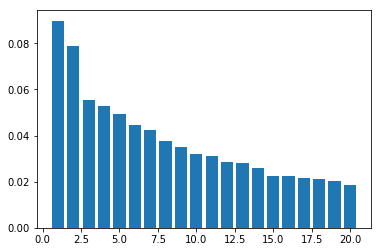

In [77]:
pca = PCA(n_components=20)

# Transform X_centered to X_pca via a fit_transform
products_cluster_counts_pca = pca.fit_transform(products_cluster_normalized)
plt.bar(range(1, 21), pca.explained_variance_ratio_)

## Clustering Products

In [78]:
# plot_kmeans_inertia(products_cluster_counts)

In [79]:
product_cluster_count = 5
km = KMeans(n_clusters=product_cluster_count)
product_clusters = km.fit_predict(products_cluster_normalized)
product_ids = df_sentence_products_clusters.index

cluster_to_product_ids = {}
for product_cluster_index in range(0, product_cluster_count):
    df_product_indexes = product_ids[product_clusters == product_cluster_index]
    product_names = df_product.loc[df_product_indexes]['product_url']
    cluster_to_product_ids[product_cluster_index] = product_names
# P116609', 'P116610'    
cluster_to_product_ids

{0: product_id
 P102503    /wrinkle-revenge-rescue-protect-facial-cream-P...
 P102504                    /wrinkle-revenge-eye-balm-P102504
 P107306                          /renewing-eye-cream-P107306
 P116609    /mega-rich-intensive-anti-aging-cellular-creme...
 P116610    /mega-rich-intensive-anti-aging-cellular-eye-c...
 P12090                  /hope-in-a-tube-eye-lip-cream-P12090
 P122727      /repairwear-anti-gravity-eye-lift-cream-P122727
 P122761                           /exfoliating-tonic-P122761
 P122774                              /all-about-eyes-P122774
 P12869               /essential-c-eye-cream-spf-15-pa-P12869
 P158702    /absolue-premium-bx-absolute-replenishing-crea...
 P159005                               /elixir-ancien-P159005
 P173620    /benefiance-wrinkleresist24-intensive-eye-cont...
 P173652    /bio-performance-advanced-super-revitalizing-c...
 P174502                         /all-about-eyes-rich-P174502
 P174629               /vita-mineral-active-7-eye-gel-P

## T-SNE

In [80]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=70).fit_transform(products_cluster_normalized)


[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1264 samples in 0.002s...
[t-SNE] Computed neighbors for 1264 samples in 0.157s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1264
[t-SNE] Computed conditional probabilities for sample 1264 / 1264
[t-SNE] Mean sigma: 0.255859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.056717
[t-SNE] Error after 1000 iterations: 1.481016


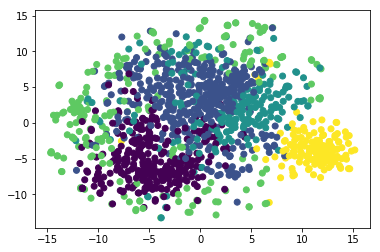

In [81]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=product_clusters)

In [82]:
# Top 5 sentences for 
# Write to CSV
df_product_filtered = df_product.loc[df_sentence_products_clusters.index]
df_product_filtered['cluster'] = product_clusters
df_product_filtered['tsne_0'] = X_embedded[:, 0]
df_product_filtered['tsne_1'] = X_embedded[:, 1]
df_product_filtered = pd.concat([df_product_filtered, df_top_features_products], axis=1)
df_product_filtered.head()

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price,cluster,tsne_0,tsne_1,5th,4th,3rd,2nd,1st
product_id,,,,,,,,,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57,0,-8.182113,-6.630831,46,15,49,42,48
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50,0,-4.670863,-6.605429,23,39,19,46,48
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80,0,-4.663054,-7.149209,40,15,0,19,48
P112400,/oil-free-facial-lotion-P112400,1605526,moisturizer & treatments,Anthony,Oil Free Facial Lotion,4.3500,"What it is:A lightweight, smoothing moisturize...",2.5,30,1,1.155634,8.068429,10,8,5,46,48
P113608,/berry-nurturing-gel-mask-P113608,1910751,face masks,OLEHENRIKSEN,Berry Nurturing Gel Mask,4.4137,Which skin type is it good for? ✔ Dry ✔ Sensit...,3.2,36,1,-2.826533,7.227691,48,16,10,46,40


In [83]:
df_product_filtered.to_csv('data/tsne_product.csv')

In [84]:
max(X_embedded[:, 0])

15.138452

In [85]:
x = np.array([[1, 2, 3], [4, 5, 6]], np.int32)
normalize(x)

array([[ 0.26726124,  0.53452248,  0.80178373],
       [ 0.45584231,  0.56980288,  0.68376346]])